### Lorenz equation generates conditioning parameters just for fun

In [1]:
# Set parameter file and model to load
from utils.myUtils import mostRecent 

# chose an existing pickledParamFile and run loadModelForEvaluation
pickledParamFile = mostRecent("../RNNControl/model/*modelParams.pkl")
#pickledParamFile = mostRecent("/home/lonce/ZCODE/PYTORCH/RNNControl/model/*modelParams.pkl")
#pickledParamFile = '/home/lonce/ZCODE/PYTORCH/HUZ/RNNControl/model.WorkingTransients/modelParams.pkl'

# choose saved model to run (defaults to the last saved if loadmodelfile is undefined or None)
# Note: looks in same directory as pickledParamFile
loadModelFileName=None
#loadModelFileName='2018-11-23_09-37-53_model_epoch1_step90.pth'
#loadModelFileName='2018-10-31_16-47-25_model_epoch1_step4000.pth'

In [2]:
# run notebook to load analysis/synthesis code
%run loadModelForEvaluation.ipynb

if 'sample_rate' not in params :   #older versions didn't save sample_rate
    params['sample_rate']=16000

python version 3.6.6
torch version 0.4.1
will read params from ../RNNControl/model/2019-01-22_12-01-39_modelParams.pkl
modelDir is ../RNNControl/model

 Saved Parameters:

{'batch_size': 256,
 'csvfile': '/home/lonce/ZCODE/PYTORCH/data/synth6476OddEvenConstantSlopeTransients_x2scaled/6476_ConstantSlopeTransient_x2scaled.csv',
 'datadir': '/home/lonce/ZCODE/PYTORCH/data/synth6476OddEvenConstantSlopeTransients_x2scaled/dataset',
 'hiNote': 76,
 'hiddenSize': 40,
 'lowNote': 64,
 'lr': 0.005,
 'max_steps': 8000,
 'nLayers': 4,
 'noise': 0.1,
 'num_epochs': 1,
 'paramdir': '/home/lonce/ZCODE/PYTORCH/data/synth6476OddEvenConstantSlopeTransients_x2scaled/dataparams',
 'props': ['instID', 'volume', 'midiPitch'],
 'runTimeStamp': '2019-01-22_12-01-39',
 'sample_rate': 16000,
 'savedModel': '2019-01-22_12-01-39_model_epoch1_step8000.pth',
 'savedSteps': 8000,
 'savemodel': True,
 'savemodel_interval': 500,
 'savemodeldir': '/home/lonce/ZCODE/PYTORCH/RNNControl/model',
 'seqLen': 512,
 'stride':

### Priming signal

In [3]:
# Make noisy nuetral Priming signal 
myp=np.zeros([1,seqLen,len(params['props'])+1])
# !! PRIMING DOES MATTER - has to be a certain level of noise
myp[0,:,0]=.3*np.random.ranf([seqLen])-.15 #signal
myp[0,:,1]= .45+.1*np.random.ranf([seqLen])     #instrument
myp[0,:,2]= .5*np.random.ranf([seqLen])    #pressure1
#myp[0,:,3]=1-myp[0,:,2]    #pressure2
myp[0,:,3]= np.random.ranf([seqLen])    #pitch
myprimer=torch.tensor(myp, dtype=torch.float)

### <font color='brown'>Generate "chaotic" trajectories in instrument, volume, and pitch using the Lorenz equation</font>

In [4]:
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from utils.Lorenz import makeLorenzTrajectory

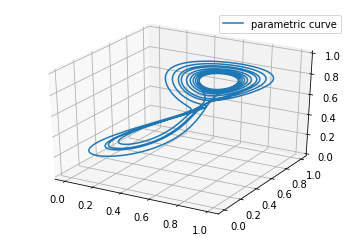

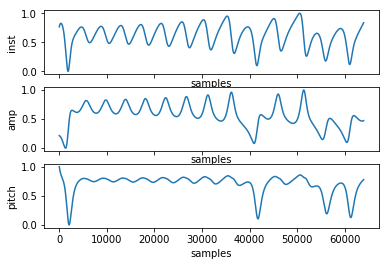

In [5]:
# Compute a 3D signal to use for parameter input to generation

genlen=4*16000    #number of samples
#the first arg is a scale param - how fast (and far) you step through the dynamical system
lorenz = makeLorenzTrajectory(10, genlen)

#Now lets look at them to see if we like 'em'
samplenums=range(genlen)

if True :   #$ plot 3D trajectory
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(lorenz[0], lorenz[1], lorenz[2], label='parametric curve')
    ax.legend()
    plt.show()
    
if True:
    f, axarr = plt.subplots(3, sharex=True, sharey=True)#, figsize=(30,30))
    props=['inst', 'amp', 'pitch']
    for i in range(3) :
        axarr[i].plot(samplenums, lorenz[i])
        axarr.flat[i].set(xlabel='samples', ylabel=props[i])

In [6]:
#Generate signal using parameter trajectories computed in previous cell

from IPython.display import Audio, display

def psweep(snum) : 
    i=lorenz[0][snum]
    v=1-lorenz[1][snum]
    p=lorenz[2][snum]
    return [i,v,p] 

y =generate(rnn, genlen, primer=None, paramvect=psweep, returnHiddenSequence=False)
display(Audio(y, rate=sr, autoplay=True))